1. Importar Bibliotecas e Configurar Ambiente

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

2. Carregar os Dados

In [3]:
# Carregar os datasets
train_path = r'D:\Documents\Estudos\Projetos\MACHINE_LEARNING\kaggle_titanic_machine_learning_from_disaster\data\raw\train.csv'
test_path = r'D:\Documents\Estudos\Projetos\MACHINE_LEARNING\kaggle_titanic_machine_learning_from_disaster\data\raw\test.csv'

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

# Visualizar os dados
print("Treinamento:")
print(train_data.head())
print("\nTeste:")
print(test_data.head())


Treinamento:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN 

3. Limpeza e Engenharia de Atributos

In [18]:
def preprocess_data(data):
    data = data.copy()

    # Preencher valores ausentes
    data['Age'].fillna(data['Age'].median(), inplace=True)
    data['Fare'].fillna(data['Fare'].median(), inplace=True)
    data['Embarked'].fillna('S', inplace=True)
    
    # Codificar variáveis categóricas
    data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})
    data['Embarked'] = data['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
    
    # Criar novos atributos
    data['FamilySize'] = data['SibSp'] + data['Parch']
    data['IsAlone'] = (data['FamilySize'] == 0).astype(int)
    
    # Selecionar atributos úteis
    features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'FamilySize', 'IsAlone']
    return data[features]


In [ ]:
# Pré-processar dados de treinamento e teste
X_train = preprocess_data(train_data)
y_train = train_data['Survived']
X_test = preprocess_data(test_data)


4. Validação Cruzada e Grid Search

In [5]:
def evaluate_model(model, param_grid, X, y, cv=5):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='accuracy',
        cv=cv,
        verbose=1,
        n_jobs=-1
    )
    grid_search.fit(X, y)
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_


5. Modelos e Hiperparâmetros

In [7]:
# Modelos e hiperparâmetros
models = {
    'Random Forest': (RandomForestClassifier(random_state=42), {
        'n_estimators': [100, 200],
        'max_depth': [5, 10],
        'min_samples_split': [2, 5]
    }),
    'XGBoost': (XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), {
        'n_estimators': [100, 150],
        'max_depth': [3, 5],
        'learning_rate': [0.05, 0.1]
    }),
    'LightGBM': (LGBMClassifier(random_state=42), {
        'n_estimators': [100, 150],
        'max_depth': [3, 5],
        'learning_rate': [0.05, 0.1]
    }),
    'Logistic Regression': (LogisticRegression(), {
        'C': [0.1, 1, 10],
        'solver': ['liblinear']
    }),
    'KNN': (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    }),
    'SVM': (SVC(random_state=42), {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    })
}


6. Testar os Modelos

In [8]:
# Avaliar os modelos
results = []
for name, (model, param_grid) in models.items():
    print(f"Treinando: {name}")
    best_model, best_params, best_score = evaluate_model(model, param_grid, X_train, y_train)
    results.append({
        'Model': name,
        'Best Params': best_params,
        'Best Score': best_score
    })

# Resultados
results_df = pd.DataFrame(results)
results_df.sort_values(by='Best Score', ascending=False, inplace=True)
print(results_df)


Treinando: Random Forest
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Treinando: XGBoost
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Treinando: LightGBM
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 218
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

7. Previsões e Submissão


Matriz de Confusão para o Modelo: XGBoost


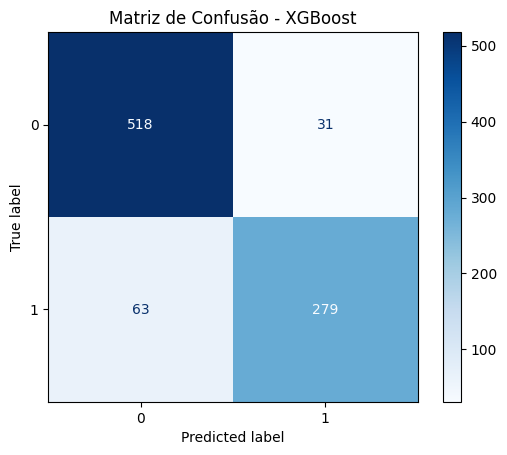

Relatório de Classificação para o Modelo: XGBoost

                 precision    recall  f1-score   support

Did Not Survive       0.89      0.94      0.92       549
       Survived       0.90      0.82      0.86       342

       accuracy                           0.89       891
      macro avg       0.90      0.88      0.89       891
   weighted avg       0.89      0.89      0.89       891

[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 218
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288
[LightGBM] [Warning] No further splits with positive g

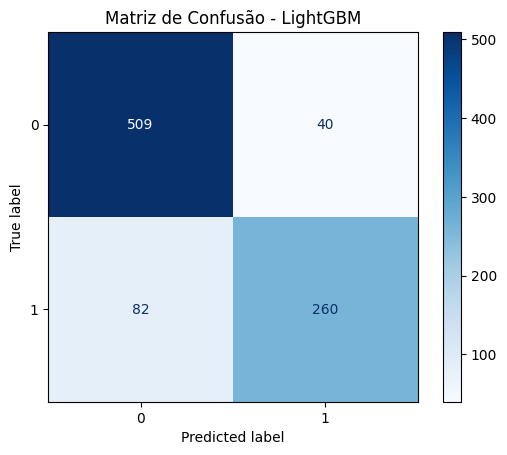

Relatório de Classificação para o Modelo: LightGBM

                 precision    recall  f1-score   support

Did Not Survive       0.86      0.93      0.89       549
       Survived       0.87      0.76      0.81       342

       accuracy                           0.86       891
      macro avg       0.86      0.84      0.85       891
   weighted avg       0.86      0.86      0.86       891


Matriz de Confusão para o Modelo: Random Forest


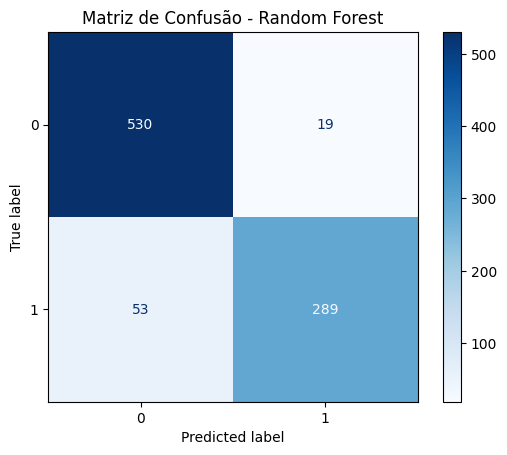

Relatório de Classificação para o Modelo: Random Forest

                 precision    recall  f1-score   support

Did Not Survive       0.91      0.97      0.94       549
       Survived       0.94      0.85      0.89       342

       accuracy                           0.92       891
      macro avg       0.92      0.91      0.91       891
   weighted avg       0.92      0.92      0.92       891



In [ ]:
# Selecionar os 3 melhores modelos
top_3_models = results_df.head(3)

# Calcular e exibir a matriz de confusão e o relatório de classificação para cada modelo
for index, row in top_3_models.iterrows():
    model_name = row['Model']
    model = models[model_name][0]  # Pegar o modelo base
    params = row['Best Params']  # Pegar os melhores hiperparâmetros

    # Reinstanciar o modelo com os melhores hiperparâmetros
    model.set_params(**params)
    model.fit(X_train, y_train)

    # Previsões no conjunto de validação
    y_pred = model.predict(X_train)

    # Calcular matriz de confusão
    conf_matrix = confusion_matrix(y_train, y_pred)

    # Calcular relatório de classificação
    class_report = classification_report(y_train, y_pred, target_names=['Did Not Survive', 'Survived'])

    # Exibir a matriz de confusão
    print(f"\nMatriz de Confusão para o Modelo: {model_name}")
    ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot(cmap='Blues')
    plt.title(f"Matriz de Confusão - {model_name}")
    plt.show()

    # Exibir o relatório de classificação
    print(f"Relatório de Classificação para o Modelo: {model_name}\n")
    print(class_report)


In [16]:
# Selecionar o melhor modelo
best_model_name = results_df.iloc[0]['Model']
print(f"Melhor Modelo: {best_model_name}")

# Treinar no conjunto completo e prever no teste
best_model = models[best_model_name][0]
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Gerar o arquivo de submissão
submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': y_pred
})


Melhor Modelo: XGBoost


In [17]:
submission.to_csv(r'D:\Documents\Estudos\Projetos\MACHINE_LEARNING\kaggle_titanic_machine_learning_from_disaster\submissions\resultado_titanic.csv', index=False)
print("Arquivo de submissão gerado: data/submission.csv")


Arquivo de submissão gerado: data/submission.csv
